In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import time
import re
import gc
from textblob import Word, TextBlob
from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.fixes import signature

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
from itertools import cycle
from scipy import interp
import warnings
warnings.filterwarnings('ignore')

# Setup Seaborn
sns.set(style='whitegrid', font_scale=0.8, rc={"lines.linewidth":2, 'grid.color': '.8', 'grid.linestyle':':'})
# Set up Matplotlib
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

In [2]:
## read dataframe from story telling procedure
df_train = pd.read_csv('./data/df_train_v4.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)
df_test = pd.read_csv('./data/df_test_v4.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)

In [3]:
df_train.head(3)

,reviewerID,asin,reviewTime,categories,helpful_num,review,polarity,word_count,word_density,helpfulness
0,A3DMPV6RWRHPM3,0306813920,2005-11-30,Books,26,"Informative, but unbalanced.. This bio gave me...",0.256913,353,5.779661,5.0
1,AZYJ9TS07B02W,B000O178BY,2007-04-19,CDs & Vinyl,8,"Boogie Apocalypse. Yeow, what a disappointment...",-0.016427,189,6.021053,2.0
2,A18U7ZLAA90PNM,B004TLH6HQ,2011-06-07,Electronics,26,False advertising - Does NOT fit IPad 2. I hav...,-0.022692,154,5.148387,5.0


In [4]:
df_test.head(3)

,reviewerID,asin,reviewTime,categories,helpful_num,review,polarity,word_count,word_density,helpfulness
0,AQRVDI6DFSZ86,B001MYIXAC,2009-04-02,Movies & TV,27,"Great Film, Great Transfer, BOGUS SUBTITLES!. ...",0.173042,252,6.351779,4.0
1,A1248JRIINWRTH,B000NQ95H0,2009-10-10,Home & Kitchen,10,Terrific quality for a great price. I was a li...,0.156119,192,5.673575,5.0
2,A2F540P3L6P5CL,0547074239,2008-08-31,Books,9,In need of some serious overhaul prior to publ...,-0.007879,197,5.474747,3.0


In [5]:
df_train.shape, df_test.shape

((994036, 10), (248510, 10))

As we did in EDA project, let's combine categories 'Electronics' and 'All Electronics' into one 'Electronics'

In [6]:
## Merge All Electronics to Electronics
df_train.categories = df_train.categories.replace({'All Electronics': 'Electronics'})
df_test.categories = df_test.categories.replace({'All Electronics': 'Electronics'})

## Tfidf features

In [7]:
## prepare stopwords to remove common 1000 frequent words
text = df_train.review.str.cat(sep=" ")
stopwords_list = Counter(text.lower().split()).most_common(1000)
stopwords_list = [item[0] for item in stopwords_list]
stopwords_set = stopwords.words('english') + stopwords_list \
                + ['quot', 'Ye', 'dr', 'etc', 'mr', 'ye', 'yes', 'paul', 'oh', 'hes', 'shes',
                  'b', 'c', 'de', 'f', 'ii', 'im', 'ive', 'la', 'michael', 'ms', 'miss', 'theres',
                  'p', 'w', 'x', 'youll', 'youre', 'youd', 'cds', 'youve', 'ill', 'theyre',
                  'theyd', 'therere', 'thats']
stopwords_set = set([re.sub("[^a-zA-Z]", "", word).lower() for word in stopwords_set]) - {""}

## read in already processed clean text dataframes
X_train_review_clean = pd.read_csv('./data/X_train_review_clean.csv.gz', header=None, compression='gzip', low_memory=False)
X_test_review_clean = pd.read_csv('./data/X_test_review_clean.csv.gz', header=None, compression='gzip', low_memory=False)

## by default, pd.read_csv reads data in dataframe. Change it to pd.Series
X_train_review_clean = X_train_review_clean[0]
X_test_review_clean = X_test_review_clean[0]

In [8]:
df_train.review.head(3)

0    Informative, but unbalanced.. This bio gave me...
1    Boogie Apocalypse. Yeow, what a disappointment...
2    False advertising - Does NOT fit IPad 2. I hav...
Name: review, dtype: object

In [9]:
X_train_review_clean.head(3)

0    informative but unbalance this bio give me a p...
1    boogie apocalypse yeow what a disappointment d...
2    false advertise do not fit ipad i have a zierr...
Name: 0, dtype: object

In [12]:
## filter out stop words of English, and too frequently used words are out, 
## words used in less than 1% and more than 90% reviews excluded
## After running several times this code block, max_df: 0.55~0.90 does not change vocabulary number 
## take top 500 frequent terms 
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), 
                             min_df=0.005, max_df=0.9, max_features=500, stop_words=stopwords_set)

V_train = vectorizer.fit_transform(X_train_review_clean.astype('U'))
V_test = vectorizer.transform(X_test_review_clean.astype('U'))

## dimension and type check
V_train.shape, V_train

((994036, 500), <994036x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 9564638 stored elements in Compressed Sparse Row format>)

## Dimension reduction with TruncatedSVD

In [13]:
## Dimension reduction to 300
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=7979)
svd.fit(V_train)

print("Reduced 300-feature data holds {:.2f} % variance of the original data".format(svd.explained_variance_ratio_.sum() * 100))

## transform arrays
V_train_new = svd.transform(V_train)
V_test_new = svd.transform(V_test)

## change to data frames
columns = ['pc'+str(i) for i in range(1, 300+1)]
V_train_new = pd.DataFrame(V_train_new, columns=columns)
V_test_new = pd.DataFrame(V_test_new, columns=columns)

## dimension check
V_train_new.shape, V_test_new.shape

Reduced 300-feature data holds 71.40 % variance of the original data


((994036, 300), (248510, 300))

## Get dummy variables for categories

In [14]:
## get dummy variabels for categories
train_cat = pd.get_dummies(df_train.categories, prefix='cat')
test_cat = pd.get_dummies(df_test.categories, prefix='cat')

## drop original review, categories columns and concatenate dummy variables
df_train = pd.concat([df_train.drop(columns=['categories']), train_cat], axis=1)
df_test = pd.concat([df_test.drop(columns=['categories']), test_cat], axis=1)

## check dimension
df_train.shape, df_test.shape

((994036, 38), (248510, 38))

## Put it all together!

In [15]:
## index reset for V_new dataframes
V_train_new.index = df_train.index
V_test_new.index = df_test.index

## Combine all data frames 
df_train = pd.concat([df_train.drop(columns=['review']), V_train_new], axis=1)
df_test = pd.concat([df_test.drop(columns=['review']), V_test_new], axis=1)

## check dimension
df_train.shape, df_test.shape

((994036, 337), (248510, 337))

In [16]:
df_train.head(3)

,reviewerID,asin,reviewTime,helpful_num,polarity,word_count,word_density,helpfulness,cat_Appliances,cat_Apps for Android,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,A3DMPV6RWRHPM3,0306813920,2005-11-30,26,0.256913,353,5.779661,5.0,0,0,...,0.015590,0.017478,0.010573,0.059862,0.051233,-0.004555,0.009048,-0.062087,0.054748,0.001599
1,AZYJ9TS07B02W,B000O178BY,2007-04-19,8,-0.016427,189,6.021053,2.0,0,0,...,-0.059889,0.011316,0.009066,0.057939,-0.019484,-0.015208,-0.003141,0.037956,0.041262,-0.108097
2,A18U7ZLAA90PNM,B004TLH6HQ,2011-06-07,26,-0.022692,154,5.148387,5.0,0,0,...,-0.007588,-0.003663,-0.010679,-0.002417,0.009921,0.001906,0.008329,-0.007434,-0.005938,-0.007134


## Standardization

In [17]:
## standardize numerical features
columns = df_train.columns.drop(['reviewerID', 'asin', 'reviewTime', 'helpfulness'])

## standardizing them
scaler = StandardScaler()
X_train = df_train[columns].copy()
X_test = df_test[columns].copy()
X_train[columns] = scaler.fit_transform(df_train[columns])
X_test[columns] = scaler.transform(df_test[columns])

## Split into predictors and response
y_train = df_train.helpfulness.astype(int)
y_test = df_test.helpfulness.astype(int)

## check dimension and summary statistics
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(994036, 333) (248510, 333) (994036,) (248510,)


,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
count,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,...,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05,9.940360e+05
mean,5.178760e-16,-2.166002e-16,-5.021578e-17,-3.793256e-15,-1.448696e-14,8.757220e-15,1.027800e-14,7.586651e-15,-5.933334e-15,-1.120757e-14,...,3.026219e-16,5.180992e-16,4.679954e-17,-2.088562e-17,2.880885e-16,-1.476404e-17,7.776454e-16,-2.265700e-17,3.130718e-16,-1.905817e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.858956e-01,-6.107773e+00,-8.906790e-01,-7.708145e+00,-3.248693e-02,-2.016406e-02,-6.454477e-02,-7.705351e-02,-8.598270e-02,-2.807702e-02,...,-6.644358e+00,-6.188888e+00,-6.504232e+00,-6.626838e+00,-6.048934e+00,-7.119678e+00,-6.373493e+00,-6.540614e+00,-6.784550e+00,-6.452385e+00
25%,-2.427416e-01,-5.158984e-01,-5.810408e-01,-6.267710e-01,-3.248693e-02,-2.016406e-02,-6.454477e-02,-7.705351e-02,-8.598270e-02,-2.807702e-02,...,-5.323144e-01,-5.327463e-01,-5.069046e-01,-5.008649e-01,-5.092769e-01,-4.788405e-01,-4.910171e-01,-4.966676e-01,-4.884351e-01,-4.919479e-01
50%,-1.711645e-01,-4.528107e-04,-3.058068e-01,-4.992810e-02,-3.248693e-02,-2.016406e-02,-6.454477e-02,-7.705351e-02,-8.598270e-02,-2.807702e-02,...,-4.044235e-03,-1.560881e-03,5.647878e-03,9.869426e-04,-1.238488e-03,-2.720205e-03,2.391959e-02,-9.617627e-03,8.231765e-03,-1.890337e-02
75%,-1.011621e-02,5.287835e-01,2.145574e-01,5.737718e-01,-3.248693e-02,-2.016406e-02,-6.454477e-02,-7.705351e-02,-8.598270e-02,-2.807702e-02,...,5.098305e-01,5.175950e-01,4.920822e-01,5.112307e-01,4.852234e-01,4.881347e-01,4.884094e-01,4.719028e-01,4.680939e-01,4.490253e-01
max,1.450049e+02,4.478493e+00,2.551028e+01,1.526134e+02,3.078161e+01,4.959320e+01,1.549312e+01,1.297799e+01,1.163025e+01,3.561632e+01,...,7.861697e+00,7.501955e+00,7.736336e+00,6.750965e+00,7.614505e+00,7.589073e+00,7.803906e+00,6.582658e+00,7.929147e+00,9.044717e+00


In [18]:
# ## For later use
# pd.concat([X_train, y_train], axis=1).to_csv('./data/df_train_final.csv.gz', encoding='utf-8', index=False, compression='gzip')
# pd.concat([X_test, y_test], axis=1).to_csv('./data/df_test_final.csv.gz', encoding='utf-8', index=False, compression='gzip')

In [19]:
X_train.head(3)

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,0.079355,0.545234,0.618807,0.407406,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.398561,0.446251,0.276731,1.539429,1.315107,-0.119982,0.232155,-1.606384,1.425175,0.039296
1,-0.242742,-0.901591,-0.086480,0.925713,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-1.532568,0.288389,0.238078,1.490016,-0.501852,-0.394231,-0.081980,0.977382,1.076143,-2.802619
2,0.079355,-0.934753,-0.236998,-0.948043,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.194436,-0.095415,-0.268150,-0.061131,0.253660,0.046343,0.213617,-0.194900,-0.145444,-0.186946


In [20]:
X_test.head(3)

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,0.097249,0.101297,0.184454,1.635836,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.262569,0.590528,-1.830406,0.564682,0.354593,-0.967970,0.631045,0.102797,0.637230,0.033021
1,-0.206953,0.011719,-0.073578,0.179622,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.718051,-0.835363,1.551426,1.299062,-1.169157,0.006471,-0.304632,-0.195367,-1.000982,0.176938
2,-0.224847,-0.856343,-0.052076,-0.247294,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.150765,-0.409631,-1.459845,0.892071,-1.331015,0.539980,-0.622941,-0.525938,1.174542,1.241735


In [21]:
# ## read dataframe from story telling procedure
# df_train = pd.read_csv('./data/df_train_final.csv.gz', compression='gzip', low_memory=False)
# df_test = pd.read_csv('./data/df_test_final.csv.gz', compression='gzip', low_memory=False)

# ## split into X, y and train and test set
# X_train = df_train.drop(columns=['helpfulness'])
# y_train = df_train.helpfulness
# X_test = df_test.drop(columns=['helpfulness'])
# y_test = df_test.helpfulness

## freeing unnecessary variables from memories
df_train = None
df_test = None
gc.collect();

## check 
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((994036, 333), (248510, 333), (994036,), (248510,))

## Machine learning frameworks
I will consider simple, somewhat simple, complex models as candidate models. That is, I will try __Logistic Regression and Gradient Boosting frameworks and evaluate them with AP (Average Precision) score__ because we have 6 class of helpfulness ($\in$ \[0, 5]) and class sizes are unbalanced (skewed downward) (Reference [this paper](https://www.biostat.wisc.edu/~page/rocpr.pdf) and [scikit-learn guide](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)). For this dataset, somehow SVM models are taking too much time for optimization, I excluded them. 

<table><tr>
    <td>
        <figure>
        <img src="https://raw.githubusercontent.com/soo-pecialist/SB_DSC/master/00_Capstone%201/Images/DataDistribution.png" style="height:300px" align='right'>
            <figcaption> (Helpfulness Distribution) </figcaption>
        </figure>
    </td>
</tr></table>

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). 

<table><tr>
    <td>
        <figure>
        <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" style="height:600px" align='right'>
            <figcaption> (Precision and Recall - wikipedia) </figcaption>
        </figure>
    </td>
</tr></table>

Above figure is a great graphical summary of precision and recall. By definition, 
- Precision is the proportion of the data points our model says was relevant actually were relevant.
- Recall is the ability to find all relevant instances in a dataset. 
More formally,

$$ Precision = \frac{True Positives}{True Positives + False Positives}$$

$$ Recall = \frac{True Positives}{True Positives + False Negatives}$$

- Average precision (AP) summarizes a precision-recall curve. You can think of it as approximated precision-recall AUC (Area Under the Curve) score. 

$$ AP = \sum_{n}(R_{n} - R_{n-1}) P_{n}$$
Where $P_n$ and $R_n$ are the precision and recall at the $n^{th}$ threshold. Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve and average precision to multi-class or multi-label classification, __it is necessary to binarize the output__. 

In [22]:
## Use label_binarize to be multi-label setting
Y_train = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5])
Y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5] )
n_classes = Y_train.shape[1]

## setting stratifiedKFold - 3 folds
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7777)

### Logistic Regression

In [23]:
## Grid Search for logistic regression
lr = OneVsRestClassifier(LogisticRegression(random_state=1004))
lr_params = {'estimator__C':[0.1, 0.5, 1, 5, 10]}

lr_grid = GridSearchCV(lr, param_grid=lr_params,
                    scoring='average_precision', 
                    cv=skf.split(X_train, y_train))

## clock running time
start = time.time()
lr_grid.fit(X_train, Y_train)
end = time.time()

print("Running time for grid search with 3-fold CV: {:.0f} (sec)".format(end-start))

Running time for grid search with 3-fold CV: 4896 (sec)


In [24]:
lr_best = lr_grid.best_estimator_
lr_score = lr_grid.best_score_
lr_params = lr_grid.best_params_

print("Best logistic regression estimator:")
print(lr_best)

Best logistic regression estimator:
OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1004, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)



In [25]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_lr_score = lr_best.predict_proba(X_test)
lr_precision = dict()
lr_recall = dict()
lr_ap = dict()
for i in range(n_classes):
    lr_precision[i], lr_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                              y_lr_score[:, i])
    lr_ap[i] = average_precision_score(Y_test[:, i], y_lr_score[:, i])

# A "micro-average": quantifying score on all classes jointly
lr_precision["micro"], lr_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                      y_lr_score.ravel())
lr_ap["micro"] = average_precision_score(Y_test, y_lr_score, average="micro")
lr_auc = roc_auc_score(Y_test, y_lr_score)
lr_precision["micro_all"], lr_recall["micro_all"], temp, _ = precision_recall_fscore_support(Y_test, lr_best.predict(X_test), average='micro')
lr_f1 = f1_score(Y_test, lr_best.predict(X_test), average='micro')
lr_acc = accuracy_score(Y_test, lr_best.predict(X_test))

print("Best logistic regression estimator micro-averaged AP score on test data:")
print("{:.4f}".format(lr_ap["micro"]))
print("Best logistic regression estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(lr_auc))

Best logistic regression estimator micro-averaged AP score on test data:
0.5014
Best logistic regression estimator micro-averaged AUC score on test data:
0.7667


### Plot the precision-Recall curve

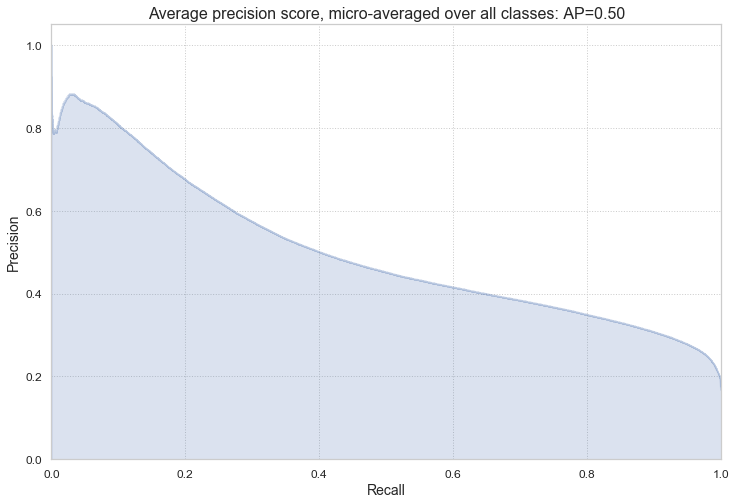

In [26]:
## helper functions
def plot_PR_curve(recall, precision, ap, n_classes = 6, is_sep=False):
    ## average plot
    if not is_sep: 
        plt.figure(figsize=(12, 8))
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                         **step_kwargs)

        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(
            'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
            .format(ap["micro"]), fontsize=16);
    ## plot for each class
    else: 
        # setup plot details
        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 
                        'teal', 'palevioletred'])

        plt.figure(figsize=(7, 8))
        f_scores = np.linspace(0.2, 0.8, num=4)
        lines = []
        labels = []
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
        l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
        lines.append(l)
        labels.append('micro-average Precision-recall (area = {0:0.2f})'
                      ''.format(ap["micro"]))

        for i, color in zip(range(n_classes), colors):
            l, = plt.plot(recall[i], precision[i], color=color, lw=2)
            lines.append(l)
            labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                          ''.format(i, ap[i]))

        fig = plt.gcf()
        fig.set_size_inches(12, 10)
        # fig.subplots_adjust(bottom=0.25)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Extension of Precision-Recall curve to multi-class', fontsize=16)
        plt.legend(lines, labels, bbox_to_anchor=(1.02, 0.04), fancybox=True, shadow=True, ncol=1, 
                   loc=(0, -.38), prop=dict(size=12))

        plt.show()

def plot_ROC_curve(y_true, y_score, n_classes=6, is_sep=False):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    
    if not is_sep:
        ## display
        plt.figure(figsize=(12, 8))
        plt.plot(fpr[2], tpr[2], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Receiver operating characteristic: AUC={:.2f}'
                  .format(roc_auc[2]), fontsize=16)
        plt.legend(loc="lower right")
        plt.show()
    else:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(12,8))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['darkgreen', 'turquoise', 'darkorange', 'cornflowerblue', 
                        'teal', 'darkmagenta'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Extension of Receiver operating characteristic to multi-class', fontsize=16)
        plt.legend(loc="lower right")
        plt.show()


## Visualize PR curve for logistic regression model
plot_PR_curve(lr_recall, lr_precision, lr_ap)

### Plot Precision-Recall curve for each class and iso-f1 curves

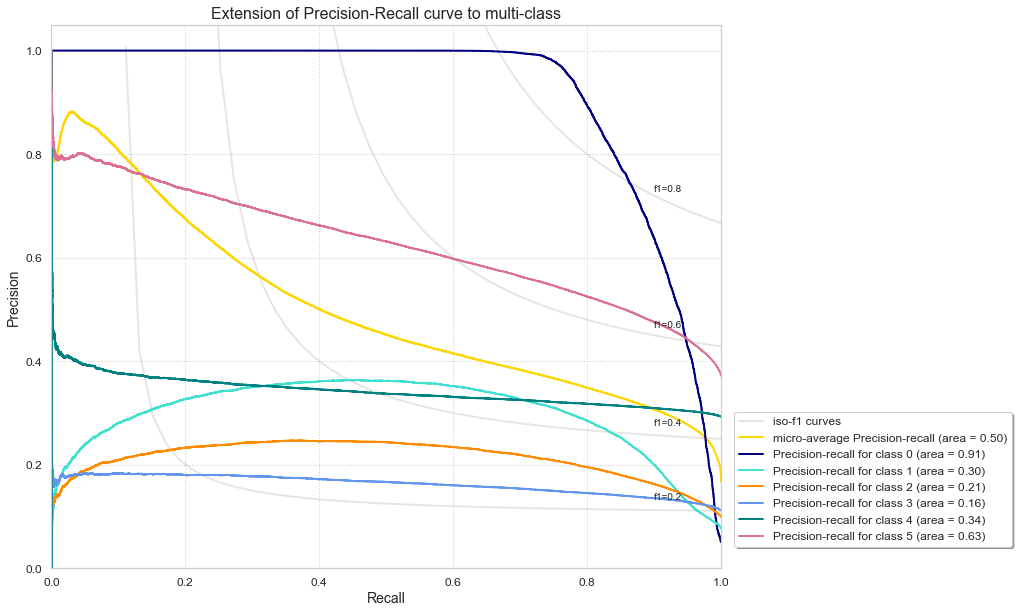

In [27]:
plot_PR_curve(lr_recall, lr_precision, lr_ap, is_sep=True)

### Plot ROC  curve 

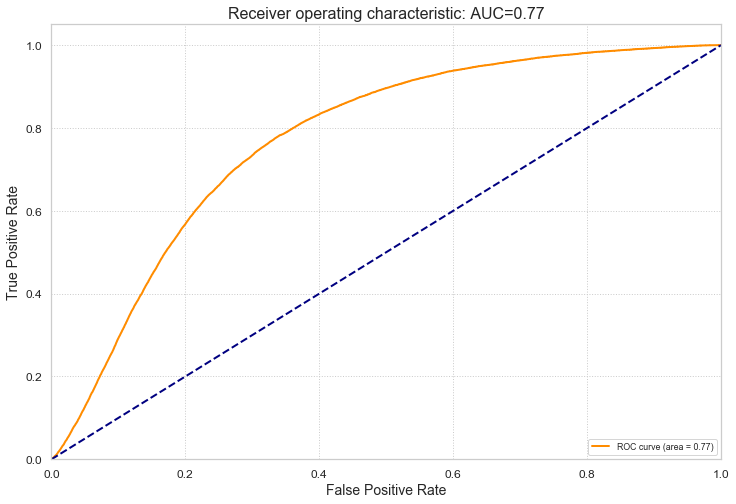

In [28]:
## Visualize ROC curve
plot_ROC_curve(Y_test, y_lr_score)

### Plot ROC curve for each class

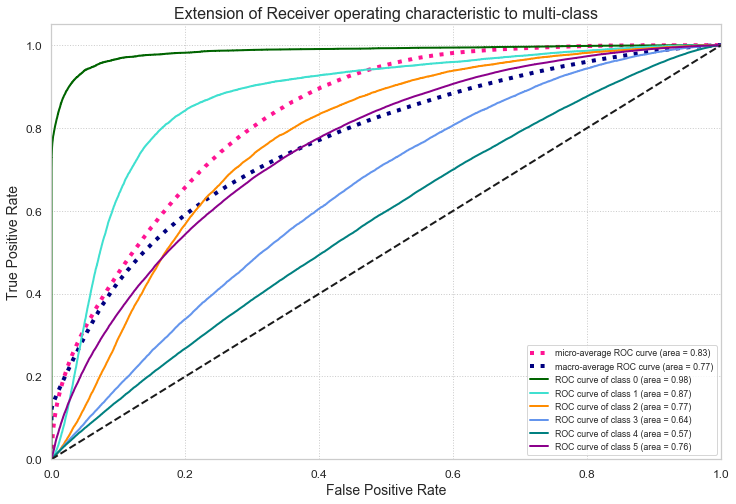

In [30]:
plot_ROC_curve(Y_test, y_lr_score, is_sep=True)

Best logistic regression model shows 0.5014 of average precision (AP) and 0.7667 of the area under the curve (AUC). As a whole, AP score does not seem so great because on average over all classes, it means 50% times model correctly predicts the score. However, when looking at individual PR curves and AP scores, logistic regression model shows good performance for class 0 and 5, which we can interpret that the logistic regression model predicts more correct on not helpful review datapoints and very helpful ones. Since I had to use one-vs-rest approach, there are some data points that model cannot determine to which class the data points belong. This would be one reason why AP and AUC scores are in general low - because those unable data points are regarded as errors. Overall, AUC scores look more promising than AP scores. However, you should keep in mind that our data is left-skewed and AUC scores are likely too optimistic in this situation. It is because, by definition, AUC scores consider TPR (True Positive Rate) and FPR (False Positive Rate), and if actual class size is small such as class 0,1,2, and 3; then it is easy to achieve good accuracy by just saying that most data points belong to other classes (This will most likely reduce False Negatives). On the other hand, big classes such as class 4 or 5 are relatively harder to achieve good accuracy. Based on AP score results, we can assume that it was easier for the learn better in class 0 and class 5 extreme classes and struggled to distinguish middle rating classes 1,2,3, and 4.

### Important predictors

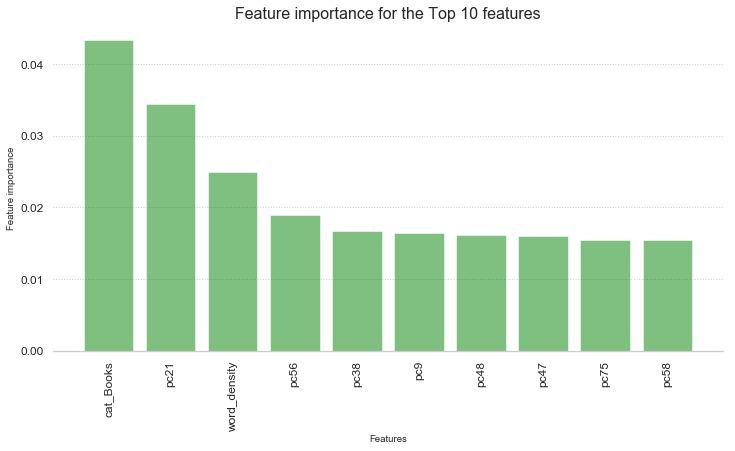

Top 10 important features:
 ['cat_Books', 'pc21', 'word_density', 'pc56', 'pc38', 'pc9', 'pc48', 'pc47', 'pc75', 'pc58']


In [40]:
## visualize it
features = sorted(zip(lr_best.coef_.mean(axis=0), X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

Logistic regression ranks feature importance based on regression coefficients. Whether it is Books category and word density play a big role to predict the helpfulness. Unfortunately, we cannot interpret those principal components such as pc21 and pc56 directly. Still, it is interesting that helpful_num, polarity, word_count did not make it to the top 10 list. Based on the logistic regression model, there exist important vocabulary groups that can help to distinguish reviews' helpfulness.

## Gradient Boosting 

### Default XGB model

In [41]:
## fit the default model to training dataset
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train, eval_metric="map")

In [42]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_xgb_score = xgb_clf.predict_proba(X_test)
xgb_precision = dict()
xgb_recall = dict()
xgb_ap = dict()
for i in range(n_classes):
    xgb_precision[i], xgb_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                                y_xgb_score[:, i])
    xgb_ap[i] = average_precision_score(Y_test[:, i], y_xgb_score[:, i])

# A "micro-average": quantifying score on all classes jointly
xgb_precision["micro"], xgb_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                        y_xgb_score.ravel())
xgb_ap["micro"] = average_precision_score(Y_test, y_xgb_score, average="micro")
xgb_auc = roc_auc_score(Y_test, y_xgb_score)
xgb_f1 = f1_score(y_test, xgb_clf.predict(X_test), average='micro')
xgb_acc = accuracy_score(y_test, xgb_clf.predict(X_test))

print("Default XGB estimator micro-averaged AP score on test data:")
print("{:.4f}".format(xgb_ap["micro"]))
print("Default XGB estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(xgb_auc))

Default XGB estimator micro-averaged AP score on test data:
0.6365
Default XGB estimator micro-averaged AUC score on test data:
0.8573


### Plot the precision-Recall curve for default XGB classifier

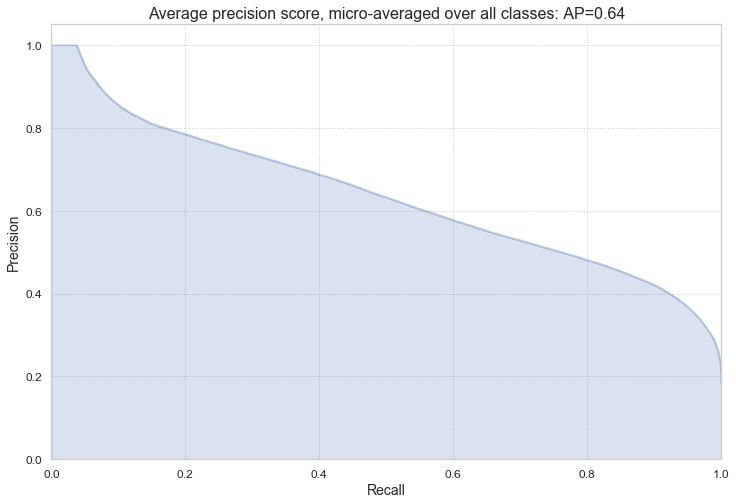

In [43]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap)

In [47]:
y_hat = xgb_clf.predict(X_test)
y_scores = xgb_clf.predict_proba(X_test)

## Let us see 20 random picked true price values and predicted price values
compare_df = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat})
ind = np.random.choice(len(compare_df), 20, replace=False)
compare_df.iloc[ind]

,y_test,y_hat
159292,4,4
96868,5,5
184102,2,2
150138,4,4
129172,4,5
44121,5,5
31031,0,0
180828,5,5
198578,4,5
110715,3,4


Default XGB classifier results in 0.6365 AP score and 0.8573 AUC score which is much better than those of optimal logistic regression model and seemingly, predicted helpfulness ratings are off of true values by 1 and this is not bad. Now we can expect better performance from optimal XG classifier by grid search cross-validation approach.

### Important predictors

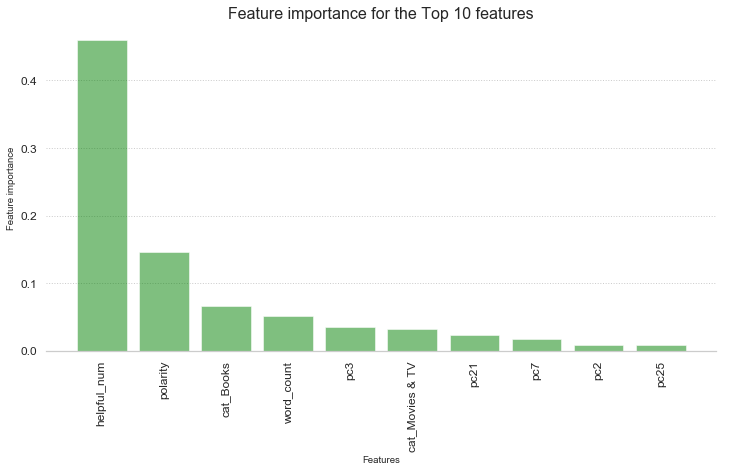

Top 10 important features:
 ['helpful_num', 'polarity', 'cat_Books', 'word_count', 'pc3', 'cat_Movies & TV', 'pc21', 'pc7', 'pc2', 'pc25']


In [48]:
## visualize it
features = sorted(zip(xgb_clf.feature_importances_, X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

According to default XGB classifier, helpful_num, polarity, cat_Books, word_count, and cat_Movies & TV play a important role to predict the review's helpfulness. This seems more reasonable than the result from the logistic regression model because as I mentioned in wrangling notebook, to get higher helpfulness rating, more people need to vote for the review. Also, polarity showed strong correlation to helpfulness (about 0.24) and so did word_count (about 0.18). Given that Books and Movies & TV categories account for about 55 % of entire dataset, we can easily suppose the model naturally focused on learning those data points in Books and Movies & TV categories. Therefore, whether the review belongs to them or not itself is an important predictor. As with the logistic model, XGB classifier implies that there exist important vocabulary groups that can help to distinguish reviews' helpfulness.

### Optimal XGB model

In [50]:
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)

## parameter dictionary holder
params = []

## candidate parameters
max_depths = [3, 4, 5] 
learning_rates = [0.01, 0.05, 0.1, 0.2]
min_child_weights = [1, 5, 10]
gammas = [0.5, 1, 1.5, 2, 5]
subsamples = [0.6, 0.8, 1]
colsample_bytrees = [0.6, 0.8, 1]

## clock running time
start = time.time()

## manually grid search cv
for max_depth in max_depths:
    for learning_rate in learning_rates:
        for min_child_weight in min_child_weights:
            for gamma in gammas:
                for subsample in subsamples:
                    for colsample_bytree in colsample_bytrees:
                        ## define hyper parameters for xgbregressor
                        param = dict(max_depth=max_depth,
                                     learning_rate=learning_rate,
                                     min_child_weight=min_child_weight,
                                     gamma=gamma, 
                                     subsample = subsample, 
                                     colsample_bytree=colsample_bytree)
                        ## retrieve cv results dataframe
                        cv_results = xgb.cv(dtrain=data_dmatrix, params=param, nfold=5, stratified=True, 
                                            num_boost_round=50, early_stopping_rounds=15, 
                                            metrics="map", as_pandas=True, seed=1108)
                        cv_score = cv_results["test-map-mean"].iloc[-1]
                        ## append the score and parameters to params
                        params.append((cv_score, param))

## clock running time
end = time.time()

## get best parameters that gives highest validation AP score
params = sorted(params, key=lambda x: x[0], reverse=True)
best_params = params[0][1]
best_valid_score = params[0][0]

print("Running time for grid search with 5-fold CV: {:.0f} (sec)".format(end-start))
print("Best XGBclassifier parameters:")
print(best_params)

Running time for grid search with 5-fold CV: 40900 (sec)
Best XGBclassifier parameters:
{'max_depth': 5, 'learning_rate': 0.2, 'min_child_weight': 1, 'gamma': 5, 'subsample': 0.8, 'colsample_bytree': 1}


In [51]:
## rerun version
start=time.time()
## train the model with best parameters
xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train, eval_metric="map")
end = time.time()
## print out results
print("Best xgb model AP score on training data:")
print(average_precision_score(Y_train, xgb_clf.predict_proba(X_train), average='micro'))
print("runtime: {:.0f}".format(end-start))

Best xgb model AP score on training data:
0.6615501673647837
runtime: 19759


In [52]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_xgb_score = xgb_clf.predict_proba(X_test)
xgb_precision = dict()
xgb_recall = dict()
xgb_ap = dict()
for i in range(n_classes):
    xgb_precision[i], xgb_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                                y_xgb_score[:, i])
    xgb_ap[i] = average_precision_score(Y_test[:, i], y_xgb_score[:, i])

# A "micro-average": quantifying score on all classes jointly
xgb_precision["micro"], xgb_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                        y_xgb_score.ravel())
xgb_ap["micro"] = average_precision_score(Y_test, y_xgb_score, average="micro")
xgb_auc = roc_auc_score(Y_test, y_xgb_score)
xgb_f1 = f1_score(y_test, xgb_clf.predict(X_test), average='micro')
xgb_acc = accuracy_score(y_test, xgb_clf.predict(X_test))

print("Best XGB estimator micro-averaged AP score on test data:")
print("{:.4f}".format(xgb_ap["micro"]))
print("Best XGB estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(xgb_auc))

Best XGB estimator micro-averaged AP score on test data:
0.6489
Best XGB estimator micro-averaged AUC score on test data:
0.8832


### Plot the precision-Recall curve for best XGB classifier

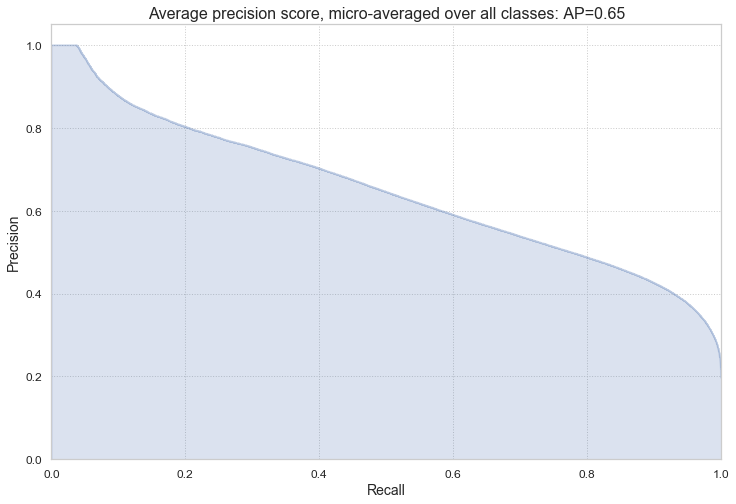

In [53]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap)

### Plot Precision-Recall curve for each class and iso-f1 curves

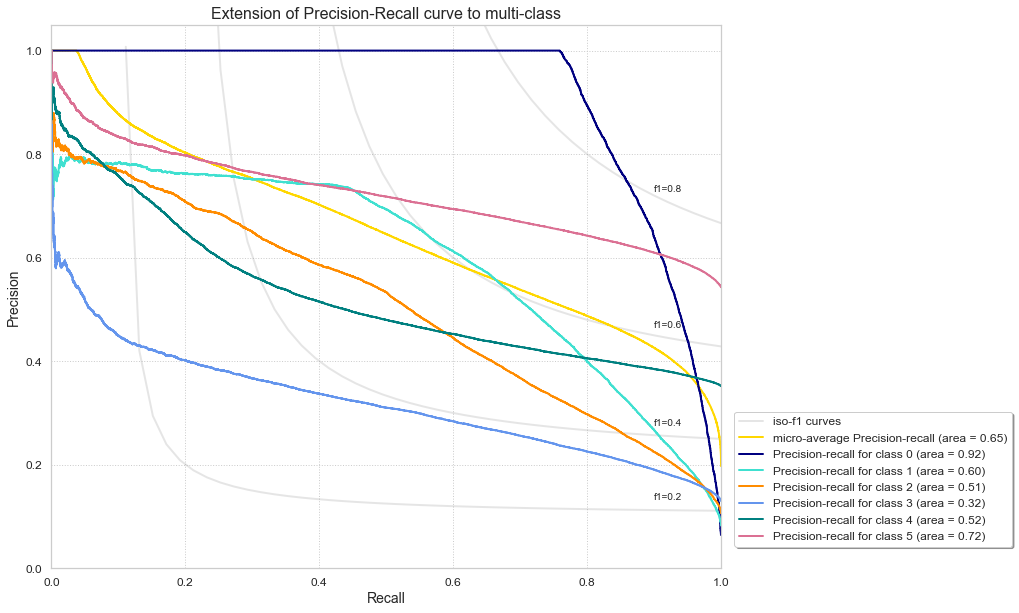

In [54]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap, is_sep=True)

### Plot ROC  curve 

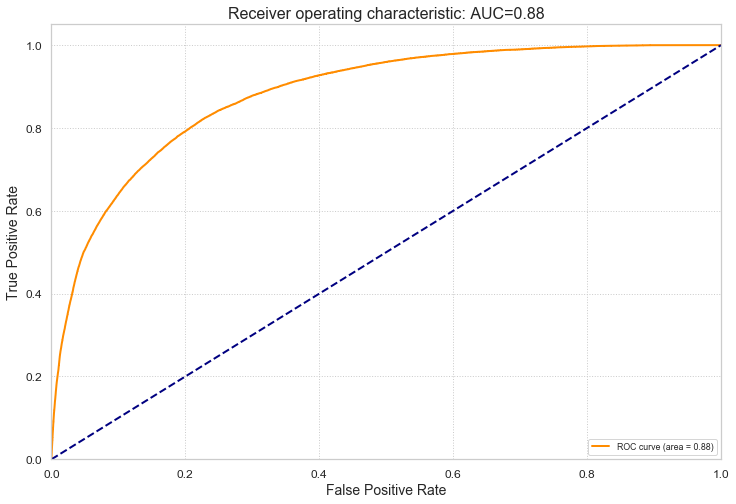

In [55]:
plot_ROC_curve(Y_test, y_xgb_score)

### Plot ROC curve for each class

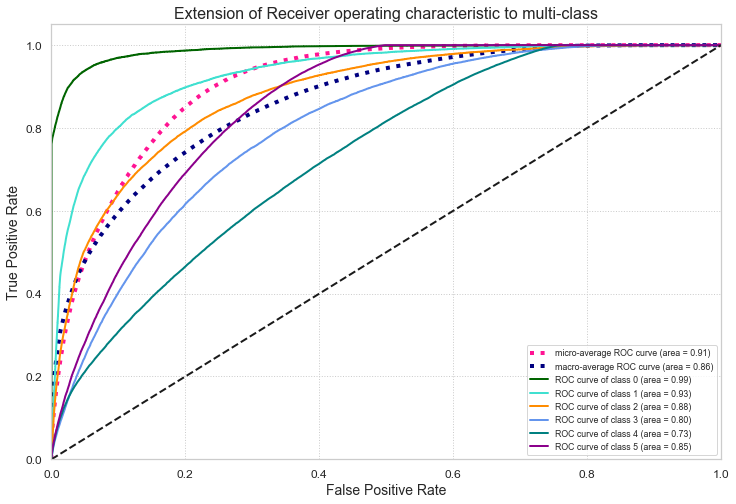

In [56]:
plot_ROC_curve(Y_test, y_xgb_score, is_sep=True)

Now, with optimal XGB classifier, we get 0.6489 of AP score and 0.8832 of AUC score. AP scores and ROC scores of individual clsses have improved compared to the optimal logistic model. Improvement in middle classes are especially noticeable. With optimal XGB classifier, we can expect more accurate prediction on helpfulness of the review.

In [57]:
y_hat = xgb_clf.predict(X_test)
y_scores = xgb_clf.predict_proba(X_test)

## Let us see 20 random picked true price values and predicted price values
compare_df = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat})
ind = np.random.choice(len(compare_df), 20, replace=False)
compare_df.iloc[ind]

,y_test,y_hat
112762,4,4
232791,5,5
127097,3,3
146880,5,5
101245,5,5
110583,2,2
149336,3,4
245482,4,5
49712,4,5
71690,5,4


Actuall helfpulness ratings are close to predicted ratings.

### Important predictors

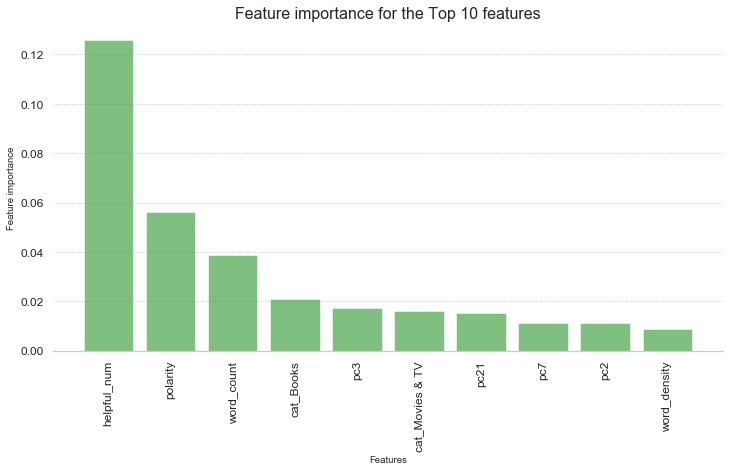

Top 10 important features:
 ['helpful_num', 'polarity', 'word_count', 'cat_Books', 'pc3', 'cat_Movies & TV', 'pc21', 'pc7', 'pc2', 'word_density']


In [58]:
## visualize it
features = sorted(zip(xgb_clf.feature_importances_, X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

According to optimal XGB classifier, top 10 important features are same except for word_density. With optimal hyper-parameters of XGB classifier, all four numerical features made it to the list. So, we can conjecture that numerical features showed strong correlation indeed play a important role to predict the response - Helpfulness rating. 

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

Confusion matrix, without normalization
[[ 9231  2127   473    93   188    51]
 [    3  9103  4943  1207  2444  1203]
 [    0  1690  9978  3370  6111  3390]
 [    0    12  1806  4387 12609  8968]
 [    0    12   246  2037 28446 41914]
 [    0     2    25   111  8124 84206]]


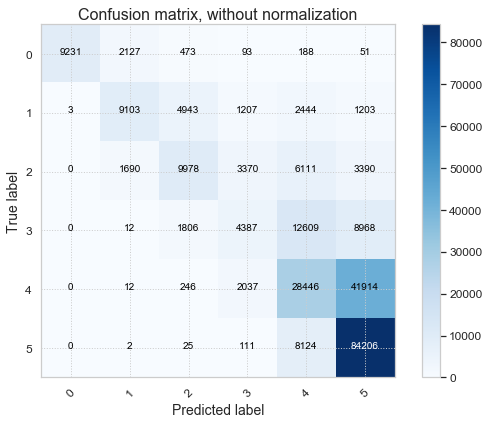

In [60]:
## compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

class_names = xgb_clf.classes_

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[7.59e-01 1.75e-01 3.89e-02 7.65e-03 1.55e-02 4.19e-03]
 [1.59e-04 4.82e-01 2.61e-01 6.39e-02 1.29e-01 6.36e-02]
 [0.00e+00 6.89e-02 4.07e-01 1.37e-01 2.49e-01 1.38e-01]
 [0.00e+00 4.32e-04 6.50e-02 1.58e-01 4.54e-01 3.23e-01]
 [0.00e+00 1.65e-04 3.39e-03 2.80e-02 3.92e-01 5.77e-01]
 [0.00e+00 2.16e-05 2.70e-04 1.20e-03 8.79e-02 9.11e-01]]


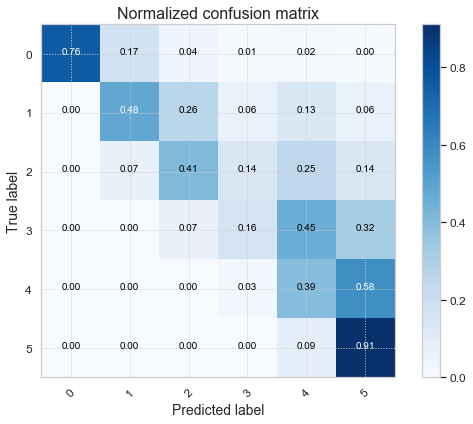

In [61]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

This normalized confusion matrix summarizes the performance of our XGB classifier. As the table from In\[54] showed, we sensed that prediction is not far off. Looking at the confusion matrix, it says the model very accurately predict class 5 reviews and class 0 ones. It still struggles with middle class reviews, but mostly the mispredicted ratings are within 1 point difference. Yet, I belive this problem can be solved simply adding more reviews of class 0, 1, 2, and 3 given that XGB classifiers hunger for data and those classes have smaller data. 
